In [7]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(dplyr)
library(rvest)
library(tidymodels)
library(GGally)
library(ISLR)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



**Introduction:** <p> Our goal for this project is to be able to predict which round of a tournament a tennis match occured, from top 128 to finals, based on relevant match data.</p> <p> The first round of a tournament begins with 128 players and after each match the number of players remaining is halved. This continues until quarterfinals(QF), then to semi-finals(SF), and ending with the grand finals(F).</p> <p>This includes data from both the winners and losers and the length of a match. This data was gathered from the 2021 matches played by athletes part of the Association of Tennis Professionals (ATP).</p>



In [2]:
tennis_data <- read_csv("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2021.csv") %>%
select(winner_name, loser_name, round, best_of, minutes, w_ace, w_svpt, winner_rank, w_bpSaved, l_ace, l_svpt, l_bpSaved, loser_rank) %>%
filter(best_of == 5)
tennis_data

tennis_split <- initial_split(tennis_data, prop = .75, strata = round)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)

Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



winner_name,loser_name,round,best_of,minutes,w_ace,w_svpt,winner_rank,w_bpSaved,l_ace,l_svpt,l_bpSaved,loser_rank
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Novak Djokovic,Jeremy Chardy,R128,5,91,9,57,1,0,3,86,7,61
Frances Tiafoe,Stefano Travaglia,R128,5,111,6,87,64,4,8,83,4,60
Reilly Opelka,Yen Hsun Lu,R128,5,115,18,84,38,1,3,92,5,1009
Taylor Fritz,Albert Ramos,R128,5,203,11,143,31,11,6,142,6,46
Stan Wawrinka,Pedro Sousa,R128,5,96,7,74,18,0,2,91,9,107
Marton Fucsovics,Marc Polmans,R128,5,252,7,151,55,9,3,160,15,126
Corentin Moutet,John Millman,R128,5,225,1,148,71,3,3,154,6,39
Milos Raonic,Federico Coria,R128,5,95,17,70,14,2,2,98,11,92
Emil Ruusuvuori,Gael Monfils,R128,5,226,4,195,86,17,13,162,7,11


In [31]:
tennis_comb <- tennis_train %>%
                drop_na() %>%
                mutate(total_ace = w_ace + l_ace) %>%
                mutate(total_svpt = w_svpt + l_svpt) %>%
                mutate(avg_rank = ((winner_rank + loser_rank)/2)) %>%
                mutate(total_bpSaved = w_bpSaved + l_bpSaved) %>%
                select(round, minutes, total_ace:total_bpSaved)
tennis_comb

round,minutes,total_ace,total_svpt,avg_rank,total_bpSaved
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
R128,111,14,170,62.0,8
R128,115,21,176,523.5,6
R128,203,17,285,38.5,17
R128,96,9,165,62.5,9
R128,225,4,302,55.0,9
R128,95,19,168,53.0,13
R128,226,17,357,48.5,24
R128,159,11,217,72.5,18
R128,156,56,253,51.0,10


In [4]:
#Table Summary of Data

tennis_group <- tennis_comb %>%
group_by(round) %>%
summarise_if(is.numeric, mean, na.rm = TRUE) %>%
arrange(3,6,5,4,2,7,1)
tennis_group

round,minutes,total_ace,total_svpt,avg_rank,total_bpSaved
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F,170.0000,21.50000,229.0000,3.25000,11.50000
QF,166.2308,20.30769,228.0000,19.38462,11.69231
R128,158.8115,19.52356,231.1047,84.74737,11.78534
R16,157.2400,17.83333,226.1667,30.15385,11.41667
R32,152.3673,17.46939,216.2449,46.81633,10.55102
R64,154.9579,18.87368,222.8737,70.67368,11.75789
SF,190.4000,21.80000,238.2000,16.20000,11.60000


Warning message:
“Removed 2 rows containing missing values (geom_point).”


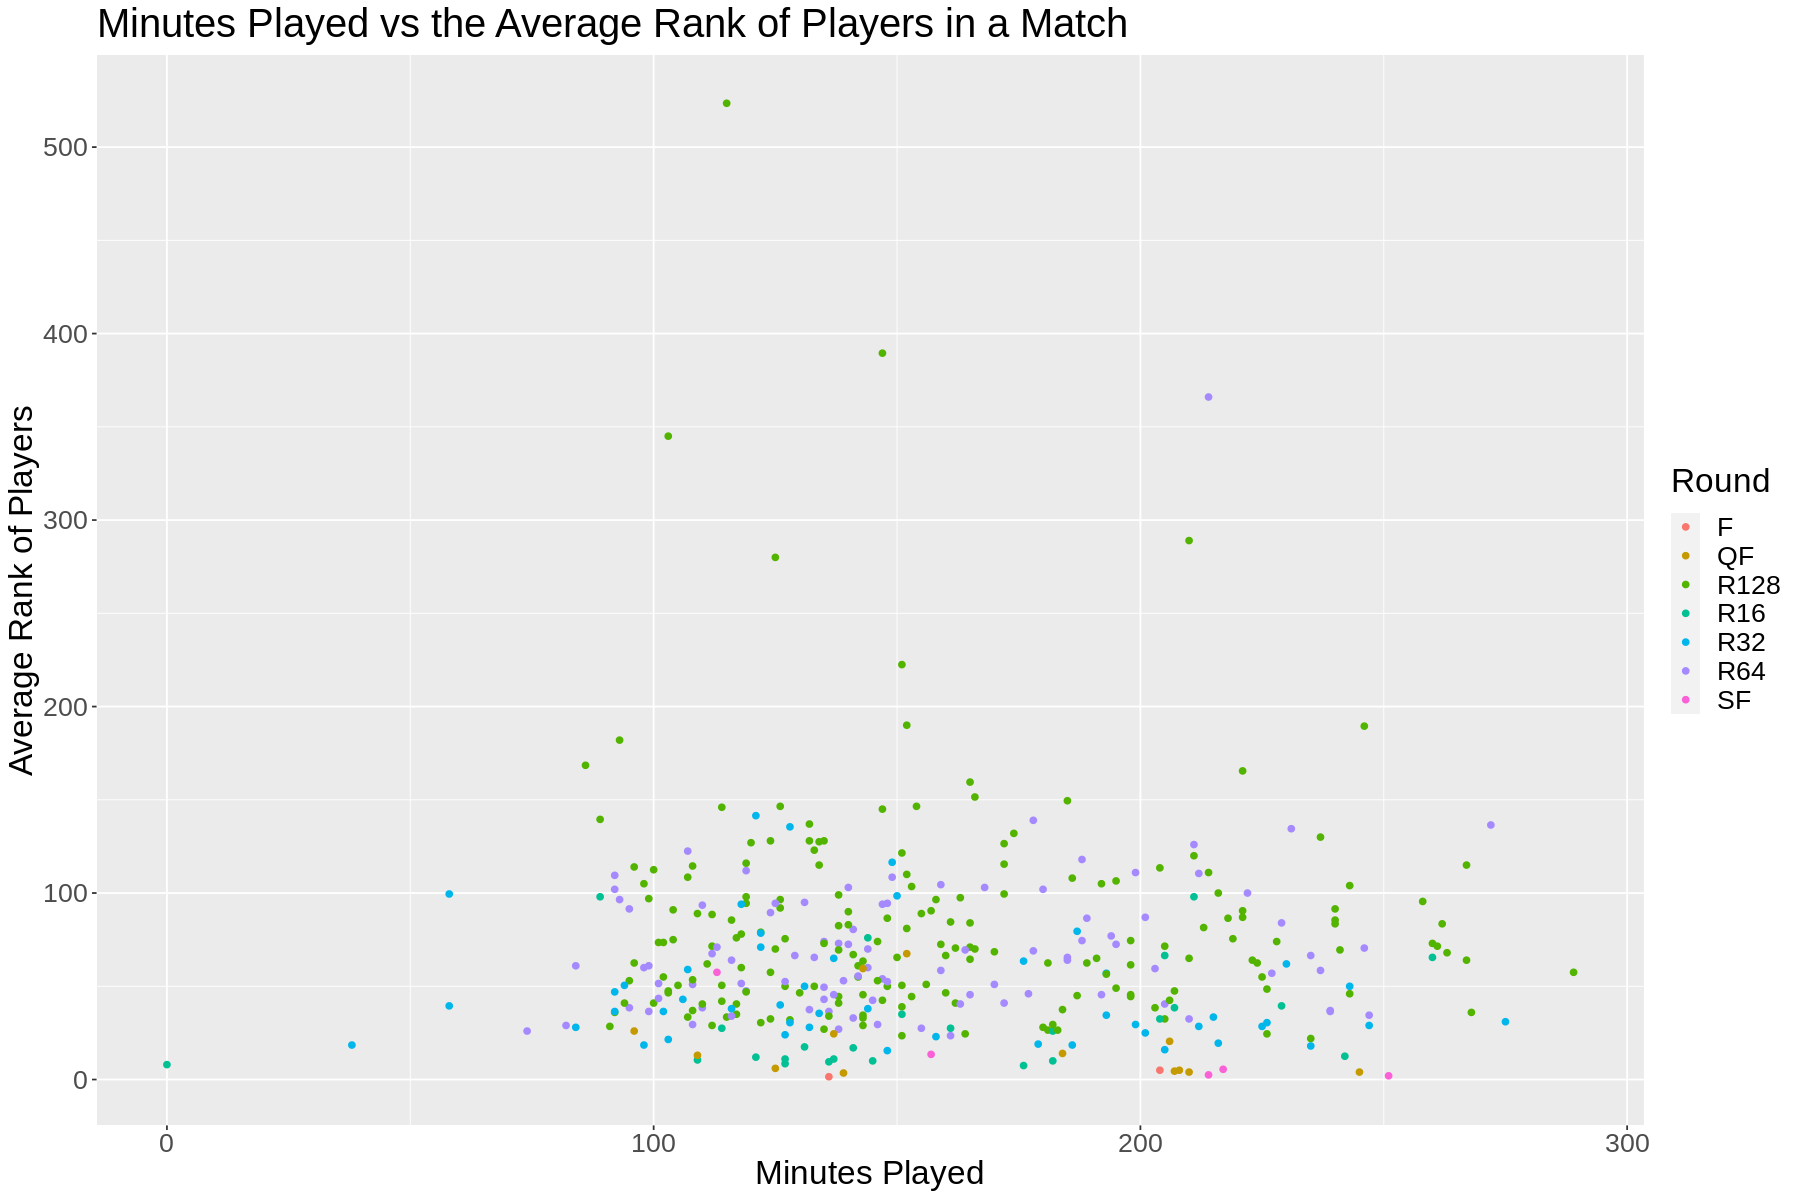

In [5]:
options(repr.plot.width = 15, repr.plot.height = 10) 

tennis_plot <- ggplot(tennis_comb, aes(x = minutes, y = avg_rank)) + 
                geom_point(aes(color = round)) +
                xlab("Minutes Played") +
                ylab("Average Rank of Players") +
                labs(color = "Round") +
                theme(text = element_text(size = 20)) + 
                ggtitle("Minutes Played vs the Average Rank of Players in a Match")
                
tennis_plot

**Method**
<p> We are predicting the round of the tennis game of two players based on the average rank and minute. We will be using columns  “round”, “minutes” and “avg_rank” to plot a scatter plot of “minutes versus average rank” and we color the data points by different rounds of games. We choose “average rank” because players with higher ranks are assumed to be in further rounds of a tournament. Also, we did not use some of the columns of the raw data set, such as “winner_hand” and “loser_hand”. These columns do not have strong relationships with rounds of a tournament,; and we can’t really say “the winner is right-handed, so this must be a quarterfinal game” and things like that.

To visualize our results our group will create plots that aim to emphasize the correlation between key predictor variables such as length of match in minutes and ATP rank of match winners. Our visualizations will consists of plots such as scatter plots and bar charts.

**What do you expect to find? What impact could these findings have?**
<p> We expect to find that rounds closer to the final had longer minutes played, as well as a lower average rank in players. As a result, we expect our algorithm to be able to determine with reasonable accuracy which round a match was played in, based on the predictors. If we managed to do so, we could predict in which round a match took place, or the level of play that the match was at. For example, even if it's the round of 128, you can have matches of a very high level, which low-ranked players and high skill. If a match was predicted to be a semi-final or final, for example, but was actually a round of 128, it can be determined that the match was one of very high skill, and that it was a good match to watch.

**Future Questions**
<p> Can the results of prediction be applied to future matches? <p> Are the outcomes of the matches of different years similar? <p> What factors influence the prediction of round? <p> How accurate is the prediction?

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



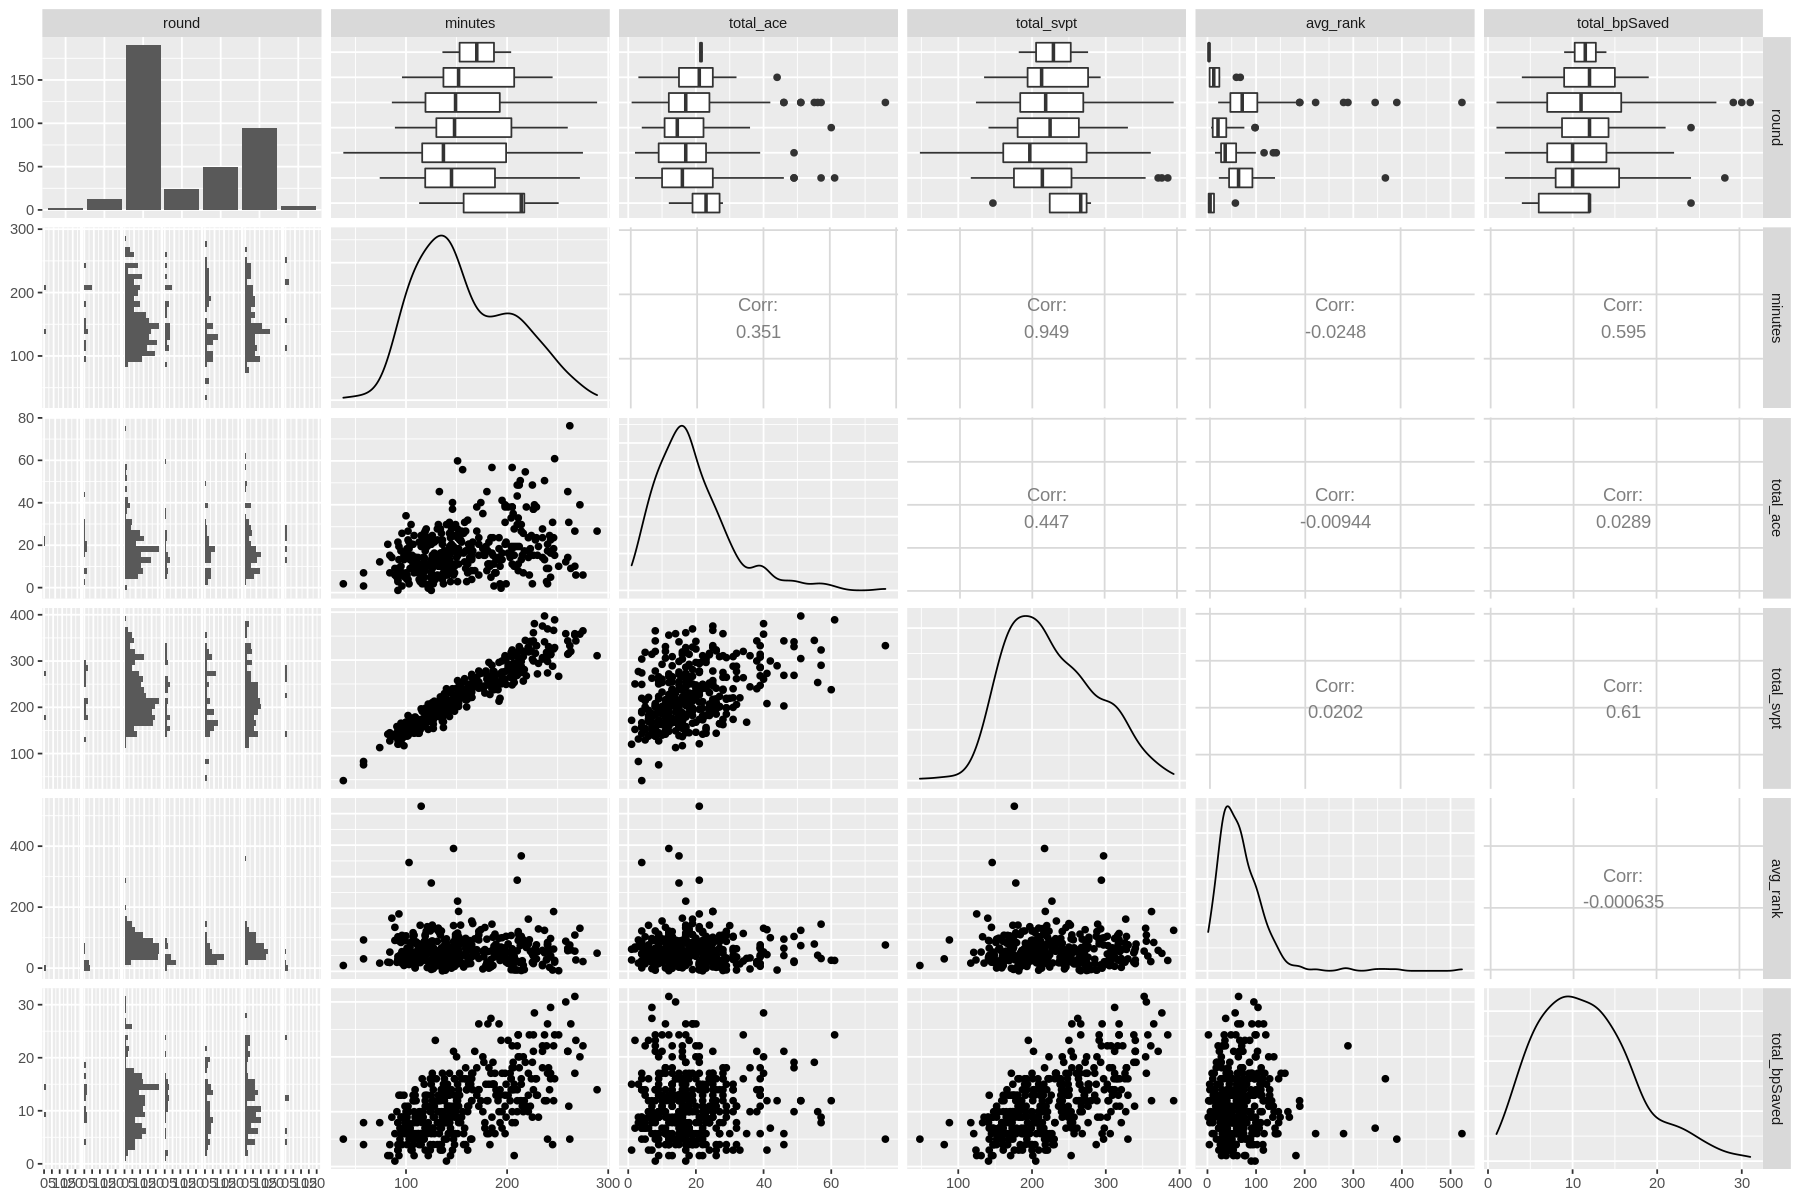

In [27]:
tennis_pairs <- ggpairs(tennis_comb, columns = 1:6)
tennis_pairs